# Notiz für Henry:
diese Datei ist dafür da das Neuronale Netz zu entwickeln. In einem Notebook kann man schneller Hyperparameter ändern und einfacher weitere kleine Änderungen vornehmen. Wenn das Gröbste steht können wir das Notebook einfach als .py Datei exportieren und sind happy

## Importieren der wichtigsten Pakete

In [1]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pandas as pd

2023-06-08 08:55:06.265304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Sinnvolle Funktionen

In [2]:
################################################################################################### 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
###################################################################################################    

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        value = f'{cm[i, j]:.3f}'  # Runde den Wert auf 3 Dezimalstellen
        plt.text(j, i, value,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
################################################################################################### 
import matplotlib.cm as cm
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[n]).reshape((28,28)), cmap=cm.Greys, interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[n],obs_errors[n]))
            n += 1
            
################################################################################################### 

In [3]:
def evaluate(X_test, Y_test):
    # Make predictions on test data
    Y_pred = model.predict(X_test)
    # Calculate loss and accuracy
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f"loss:     {loss:.3}")
    print(f"accuracy: {accuracy:.3}")

    # Compute the classification report
    report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    print(report)
    
    # Plot probability of being zero for true !genre! and non-!genre!
    true_genre = np.where(np.argmax(Y_test, axis=1) == 0)[0]
    true_non_genre = np.where(np.argmax(Y_test, axis=1) != 0)[0]
    
    plt.figure()
    plt.hist(Y_pred[true_genre, 0], bins=50, color='red', label='True !genre!', alpha=0.5)
    plt.hist(Y_pred[true_non_genre, 0], bins=50, color='blue', label='True Non-!genre!', alpha=0.5)
    plt.xlabel('Probability of !hier genre einfügen!')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(confusion_mtx, classes=range(10), normalize='true')  

## Laden der Daten
am besten wir fügen das Genre in einer separaten Datei dem Datensatz hinzu und machen ab hier nur mit dem fertigen Datensatz weiter

## Convert target

In [4]:
csv_file = "../data/data_selected.csv"

df = pd.read_csv(csv_file)
df.columns

Index(['Unnamed: 0', 'Artist', 'Url_spotify', 'Track', 'Album', 'Album_type',
       'Uri', 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Url_youtube', 'Title', 'Channel', 'Views', 'Likes',
       'Comments', 'Description', 'Licensed', 'official_video', 'Stream',
       'Genre'],
      dtype='object')

In [7]:
features_drop = ['Genre', 
                 'Artist', 
                 'Url_spotify', 
                 'Track', 
                 'Album', 
                 'Album_type', 
                 'Uri', 
                 'Url_youtube', 
                 'Title', 
                 'Channel', 
                 'Views', 
                 'Likes', 
                 'Comments', 
                 'Description', 
                 'Licensed', 
                 'official_video', 
                 'Stream'
                ]
X = df.drop(features_drop, axis=1)
Y = df['Genre']

In [8]:
# One-Hot-Encoding durchführen
Y = pd.get_dummies(Y)

## Splitten von Training und Test Datensätzen

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

## Daten skalieren

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


## Modell
hier ein schönes Modell ergänzen

In [12]:
num_classes = len(Y.value_counts())

model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))  
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(units=num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                416       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 58)                3770      
                                                                 
Total params: 6,298
Trainable params: 6,298
Non-trainable params: 0
_________________________________________________________________


## Training

In [14]:
batch_size = 64
nb_epoch =100

hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_val, Y_val))

Epoch 1/100
94/94 [==============================] - 3s 11ms/step - loss: 3.1872 - accuracy: 0.2472 - val_loss: 2.6565 - val_accuracy: 0.3120
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 2.5854 - accuracy: 0.3143 - val_loss: 2.4960 - val_accuracy: 0.3374
Epoch 3/100
94/94 [==============================] - 1s 7ms/step - loss: 2.4618 - accuracy: 0.3291 - val_loss: 2.4278 - val_accuracy: 0.3428
Epoch 4/100
94/94 [==============================] - 1s 7ms/step - loss: 2.4128 - accuracy: 0.3447 - val_loss: 2.3906 - val_accuracy: 0.3464
Epoch 5/100
94/94 [==============================] - 1s 7ms/step - loss: 2.3742 - accuracy: 0.3450 - val_loss: 2.3640 - val_accuracy: 0.3491
Epoch 6/100
94/94 [==============================] - 1s 7ms/step - loss: 2.3313 - accuracy: 0.3581 - val_loss: 2.3424 - val_accuracy: 0.3522
Epoch 7/100
94/94 [==============================] - 1s 7ms/step - loss: 2.3154 - accuracy: 0.3561 - val_loss: 2.3286 - val_accuracy: 0.3573
Epoch 8/100


## Vorhersage

In [15]:
Y_pred = model.predict(X_test)

115/115 [==============================] - 1s 4ms/step


## Evaluation

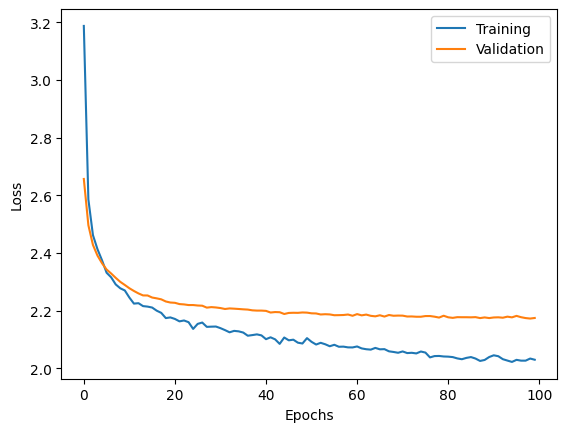

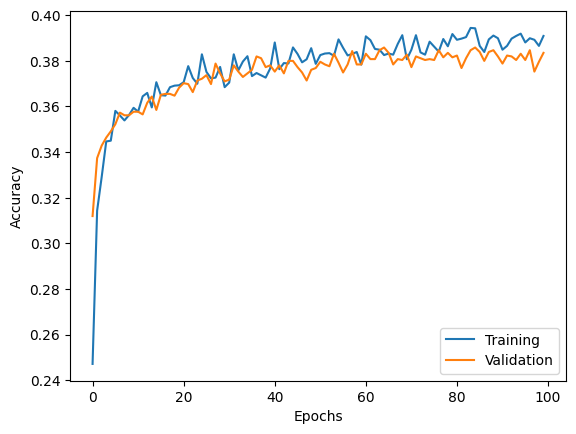

In [16]:
plot_history(hist)

115/115 [==============================] - 1s 5ms/step
loss:     2.11
accuracy: 0.401
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00       139
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        11
           6       0.29      0.19      0.23       238
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        59
          11       0.00      0.00      0.00         6
          12       0.46      0.19      0.27       159
          13       0.67      0.21      0.32        19
          14       0.00      0.00      0.00         9
          15       0.40      0.88      0.55      

/home/christopher/mambaforge/envs/smd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/christopher/mambaforge/envs/smd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/christopher/mambaforge/envs/smd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

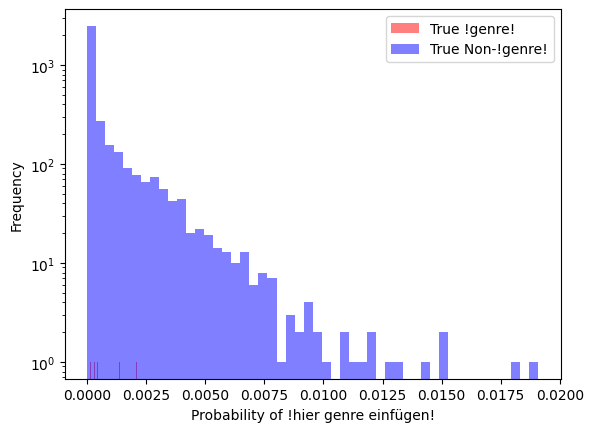

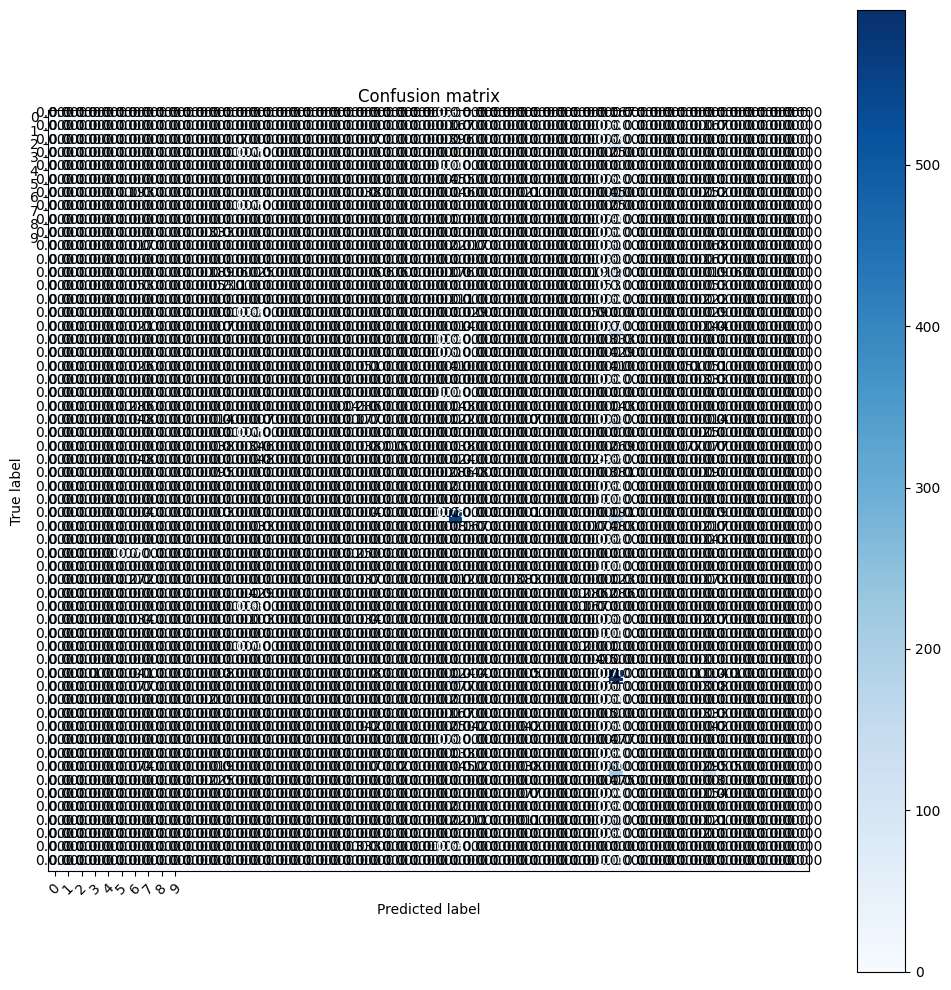

In [17]:
evaluate(X_test, Y_test)